In [2]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import community as community_louvain
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from random import uniform


In [3]:
# --- Load POS tags with attributes ---
with open("pos_tags.json", "r", encoding="utf-8") as f:
    pos_tags = json.load(f)

In [4]:
def load_weighted_graph_pmi(file):
    node1_counts = Counter()
    node2_counts = Counter()
    co_occurrence_counts = Counter()

    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) != 3:
                continue

            node1, node2, weight = parts
            weight = int(weight)

            node1_counts[node1] += weight
            node2_counts[node2] += weight
            co_occurrence_counts[(node1, node2)] += weight

    total_count = sum(co_occurrence_counts.values())
    pmi_values = {}

    for (node1, node2), co_count in co_occurrence_counts.items():
        p_node1 = node1_counts[node1] / total_count
        p_node2 = node2_counts[node2] / total_count
        p_co = co_count / total_count

        pmi = np.log2(p_co / (p_node1 * p_node2))
        pmi_values[(node1, node2)] = pmi
    
    G = nx.Graph()
    for (node1, node2), pmi in pmi_values.items():
        G.add_edge(node1, node2, pmi=pmi)
        for w in (node1, node2):
            if w in pos_tags:
                G.nodes[w]['pos'] = pos_tags[w]['pos']
                G.nodes[w]['gender'] = pos_tags[w]['gender']
                G.nodes[w]["embedding"] = pos_tags[w]["embedding"]
            else:
                G.nodes[w]["pos"] = None
                G.nodes[w]["gender"] = None
                G.nodes[w]["embedding"] = None

    return G

G_male = load_weighted_graph_pmi("male_pairs_w.txt")
G_female = load_weighted_graph_pmi("female_pairs_w.txt")
G_mixed = load_weighted_graph_pmi("mixed_pairs_w.txt")

In [5]:
G_male_cleaned = G_male.copy()
G_female_cleaned = G_female.copy()

for node in list(G_mixed.nodes):
    if G_mixed.nodes[node]['pos'] in ['ADJ', 'VERB', 'NOUN']:
        G_male_cleaned.remove_node(node) if G_male_cleaned.has_node(node) else None
        G_female_cleaned.remove_node(node) if G_female_cleaned.has_node(node) else None
        #remove isolated nodes
        if G_male_cleaned.degree(node) == 0:
            G_male_cleaned.remove_node(node)
        if G_female_cleaned.degree(node) == 0:
            G_female_cleaned.remove_node(node)

In [6]:
graphs = [G_male, G_female, G_male_cleaned, G_female_cleaned]
for graph in graphs:
    print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

Graph has 9974 nodes and 233363 edges.
Graph has 4670 nodes and 61274 edges.
Graph has 7078 nodes and 39114 edges.
Graph has 2636 nodes and 8597 edges.


In [7]:
print("Prior removal of similar edges\n")
print("Number of edges in G_male:", G_male.number_of_edges())
print("Number of edges in G_female:", G_female.number_of_edges())

Prior removal of similar edges

Number of edges in G_male: 233363
Number of edges in G_female: 61274


In [8]:
G_male_copy = G_male.copy()
G_female_copy = G_female.copy()

for node1, node2, pmi_male in G_male.edges(data="pmi"):
    if G_female.has_edge(node1, node2):
        pmi_female = G_female.edges[node1, node2]["pmi"]

        if abs(pmi_male-pmi_female) < 3:  # use standard deviation as threshold?
            G_male_copy.remove_edge(node1, node2)
            G_female_copy.remove_edge(node1, node2)
#remove edges that appear in g_mixed
for node1, node2 in G_mixed.edges():
    if G_male_copy.has_edge(node1, node2):
        G_male_copy.remove_edge(node1, node2)
    if G_female_copy.has_edge(node1, node2):
        G_female_copy.remove_edge(node1, node2)
#remove isolated nodes
for node in list(G_male_copy.nodes):
    if G_male_copy.degree(node) == 0:
        G_male_copy.remove_node(node)
for node in list(G_female_copy.nodes):
    if G_female_copy.degree(node) == 0:
        G_female_copy.remove_node(node)

In [9]:
print("Post removal of similar edges\n")
print("Number of edges in G_male_pmi:", G_male_copy.number_of_edges())
print("Number of edges in G_female_pmi:", G_female_copy.number_of_edges())

Post removal of similar edges

Number of edges in G_male_pmi: 199499
Number of edges in G_female_pmi: 44757


In [10]:
print(f"Number of edges removed from the graphs: {G_male.number_of_edges()-G_male_copy.number_of_edges()}")

Number of edges removed from the graphs: 33864


In [11]:
# Top 20 edges with highest PMI
top_20_pmi_male = sorted(G_male_copy.edges(data="pmi"), key=lambda x: x[2], reverse=True)[:20]
top_20_pmi_female = sorted(G_female_copy.edges(data="pmi"), key=lambda x: x[2], reverse=True)[:20]

print("Top 20 edges with highest PMI in males:" )
for e in top_20_pmi_male:
    print(e)
print("-----"*20)
print("\nTop 20 edges with highest PMI in females:" )
for e_ in top_20_pmi_female:
    print(e_)  

Top 20 edges with highest PMI in males:
('ludwig-van-beethoven', 'pastoral', np.float64(17.533158602900553))
('symphony', 'pastoral', np.float64(17.533158602900553))
('johann-sebastian-bach', 'fugue', np.float64(16.9481961021794))
('ludwig-van-beethoven', 'symphony', np.float64(16.533158602900553))
('stocky', 'ox', np.float64(16.21123050801319))
('hearted', 'cold', np.float64(16.21123050801319))
('viktor-tikhonov', 'vladimir-myshkin', np.float64(16.21123050801319))
('slumlord', 'slum', np.float64(16.21123050801319))
('valuable', 'ward', np.float64(16.21123050801319))
('wreckage', 'wristwatch', np.float64(16.21123050801319))
('deranged', 'gigantopithecus', np.float64(16.21123050801319))
('frugality', 'charley-appleby', np.float64(16.21123050801319))
('skid', 'swerve', np.float64(16.21123050801319))
('powerless', 'ron-wilson', np.float64(16.21123050801319))
('spork', 'orientation', np.float64(16.21123050801319))
('terrorize', 'sorceress', np.float64(16.21123050801319))
('irendri', 'anga-

In [12]:
def top_20_by_degree_centrality(G, gender):
    degree_centrality = nx.degree_centrality(G)
    sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 20 nodes by degree centrality in {gender}-associated graph:")
    for node, centrality in sorted_nodes[:20]:
        print(f"Node: {node}, Degree Centrality: {centrality:.4f}")

In [13]:
top_20_by_degree_centrality(G_male_copy, "male")
top_20_by_degree_centrality(G_female_copy, "female")

Top 20 nodes by degree centrality in male-associated graph:
Node: take, Degree Centrality: 0.1161
Node: find, Degree Centrality: 0.1112
Node: name, Degree Centrality: 0.0958
Node: friend, Degree Centrality: 0.0939
Node: use, Degree Centrality: 0.0913
Node: return, Degree Centrality: 0.0900
Node: help, Degree Centrality: 0.0895
Node: leave, Degree Centrality: 0.0885
Node: go, Degree Centrality: 0.0883
Node: become, Degree Centrality: 0.0878
Node: give, Degree Centrality: 0.0875
Node: tell, Degree Centrality: 0.0844
Node: make, Degree Centrality: 0.0838
Node: reveal, Degree Centrality: 0.0836
Node: discover, Degree Centrality: 0.0820
Node: back, Degree Centrality: 0.0804
Node: try, Degree Centrality: 0.0794
Node: get, Degree Centrality: 0.0785
Node: escape, Degree Centrality: 0.0779
Node: lead, Degree Centrality: 0.0770
Top 20 nodes by degree centrality in female-associated graph:
Node: find, Degree Centrality: 0.0617
Node: jim, Degree Centrality: 0.0543
Node: take, Degree Centrality: 0.

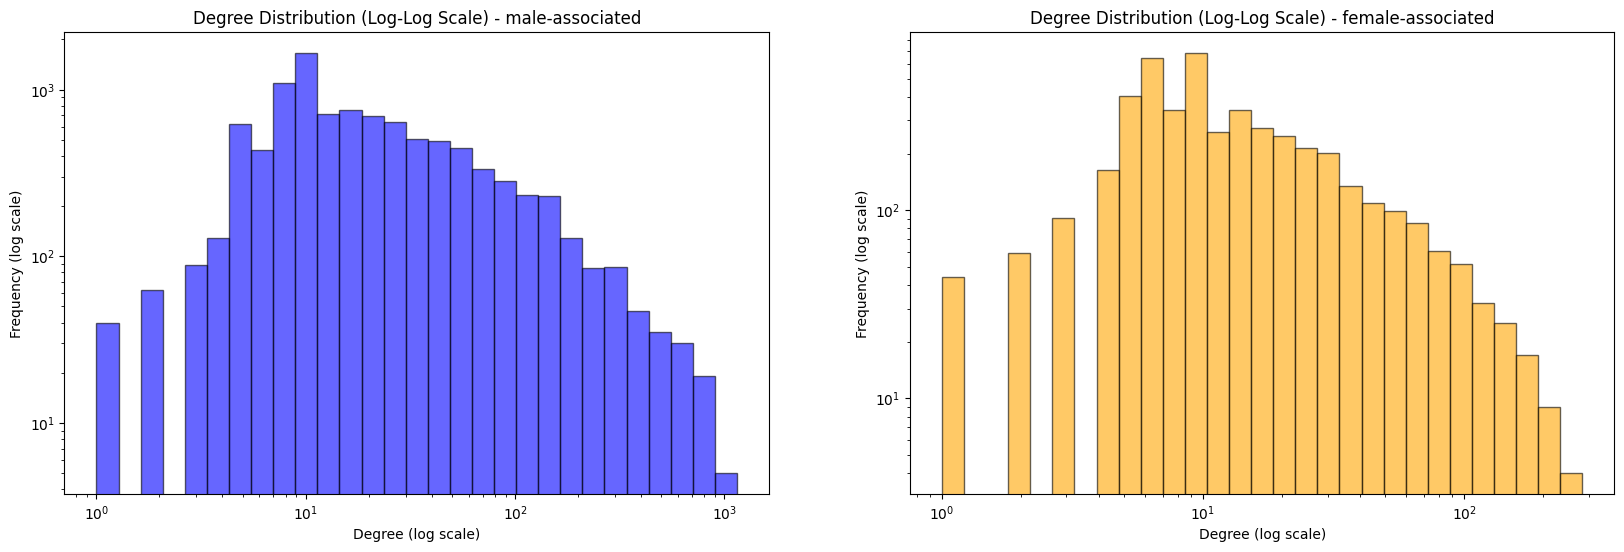

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_degree_dist_log(graph_male, graph_female):
    degrees_male = list(dict(graph_male.degree()).values())
    degrees_female = list(dict(graph_female.degree()).values())
    
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    plt.hist(degrees_male, bins=np.logspace(np.log10(min(degrees_male)), np.log10(max(degrees_male)), 30), color='blue', alpha=0.6, edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Degree Distribution (Log-Log Scale) - male-associated')

    plt.subplot(1, 2, 2)
    plt.hist(degrees_female, bins=np.logspace(np.log10(min(degrees_female)), np.log10(max(degrees_female)), 30), color='orange', alpha=0.6, edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Degree Distribution (Log-Log Scale) - female-associated')

    plt.show()
plot_degree_dist_log(G_male_copy,G_female_copy)
plt.savefig("plots/degree_distribution_log_log.png")

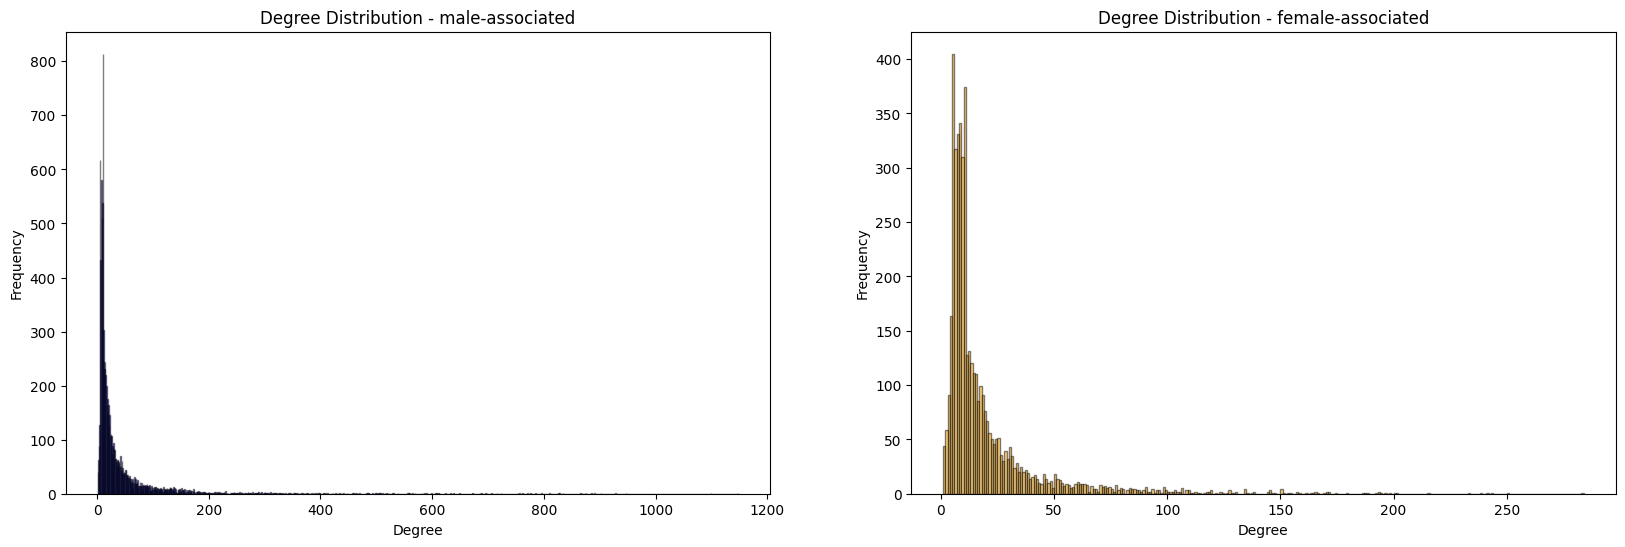

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_degree_dist(graph_male, graph_female):
    degree_male = dict(graph_male.degree())
    min_degree_m, max_degree_m = min(degree_male.values()), max(degree_male.values())
    degree_vector_m = np.arange(min_degree_m, max_degree_m + 1)
    degree_hist_m = np.histogram(list(degree_male.values()), bins=degree_vector_m)

    degree_female = dict(graph_female.degree()) 
    min_degree_f, max_degree_f = min(degree_female.values()), max(degree_female.values())
    degree_vector_f = np.arange(min_degree_f, max_degree_f + 1)
    degree_hist_f = np.histogram(list(degree_female.values()), bins=degree_vector_f)



    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.hist(degree_male.values(), bins=degree_hist_m[1], color='blue', alpha=0.5, edgecolor='black')
    plt.title('Degree Distribution - male-associated')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    plt.hist(degree_female.values(), bins=degree_hist_f[1], color='orange', alpha=0.5, edgecolor='black')
    plt.title('Degree Distribution - female-associated')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

plot_degree_dist(G_male_copy, G_female_copy)
plt.savefig("plots/degree_distribution.png")

In [16]:
sorted(G_male_copy.degree(), key=lambda x: x[1], reverse=True)[:10], sorted(G_female_copy.degree(), key=lambda x: x[1], reverse=True)[:10]

([('take', 1148),
  ('find', 1099),
  ('name', 947),
  ('friend', 928),
  ('use', 902),
  ('return', 890),
  ('help', 885),
  ('leave', 875),
  ('go', 873),
  ('become', 868)],
 [('find', 284),
  ('jim', 250),
  ('take', 243),
  ('name', 241),
  ('daughter', 238),
  ('mother', 233),
  ('leave', 215),
  ('family', 201),
  ('give', 200),
  ('girl', 198)])

In [17]:
def get_connected_component(graph):
    #get connected components
    connected_components = list(nx.connected_components(graph))
    print(f"Number of connected components: {len(connected_components)}")
    largest_cc = max(connected_components, key=len)
    G_largest = graph.subgraph(largest_cc)
    print(f"Largest connected component size: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")
    #num of genders in largest cc
    genders_in_largest_cc = [G_largest.nodes[node]["gender"] for node in G_largest.nodes() if G_largest.nodes[node]["gender"] is not None]
    dict_largest_cc = {}
    for gender in genders_in_largest_cc:
        if gender not in dict_largest_cc:
            dict_largest_cc[gender] = 1
        else:
            dict_largest_cc[gender] += 1 
    print(f'Gender distribution of graph')
    print(dict_largest_cc)
    return G_largest

m_largest= get_connected_component(G_male_copy)
f_largest= get_connected_component(G_female_copy)

Number of connected components: 2
Largest connected component size: 9882 nodes, 199496 edges
Gender distribution of graph
{'male': 2056, 'female': 42}
Number of connected components: 1
Largest connected component size: 4604 nodes, 44757 edges
Gender distribution of graph
{'female': 610, 'male': 106}


In [18]:
def detect_communities(graph):
    """Detect communities in the graph using the Louvain method."""
    # Perform community detection
    partition = community_louvain.best_partition(graph, weight='pmi')

    num_communities = len(set(partition.values()))
    print(f"Number of communities detected: {num_communities}")

    partition_sizes = Counter(partition.values())
    largest_partitions = partition_sizes.most_common(4)
    top_community_ids = [comm_id for comm_id, size in largest_partitions]

    print("Sizes of the 4 largest communities:")
    print(sorted(largest_partitions, key=lambda x: x[1], reverse=True))

    #we compute the centroid vector for each community, this is the average of the embedding vectors of the nodes in that community
    community_vectors = {}
    for comm_id in set(partition.values()):
        nodes = [n for n, c in partition.items() if c == comm_id]
        vecs = np.array([graph.nodes[n]['embedding'] for n in nodes if graph.nodes[n]['embedding'] is not None])
        if len(vecs) > 0:
            community_vectors[comm_id] = vecs.mean(axis=0)
            
    #calculate modularity
    modularity = community_louvain.modularity(partition, graph, weight='pmi')
    print(f"Modularity of the partition: {modularity:.4f}")
    
    return partition, top_community_ids, community_vectors

In [19]:
m_communities, m_communities_ids, m_community_vectors = detect_communities(m_largest)
f_communities, f_communities_ids, f_community_vectors = detect_communities(f_largest)

Number of communities detected: 32
Sizes of the 4 largest communities:
[(0, 577), (25, 448), (4, 446), (17, 446)]
Modularity of the partition: 0.2736
Number of communities detected: 35
Sizes of the 4 largest communities:
[(34, 247), (15, 188), (7, 168), (20, 166)]
Modularity of the partition: 0.4183


Community detection revealed 31 communities in both networks. The male network has a modularity of 0.274, which indicates moderate community structure, with a few very large communities dominating the network. In contrast, the femlae network shows higher modularity (0.419), which suggests more pronounced and well-separated communities, with the largest communities being smaller and more balanced.

In [20]:
for node, comm_id in m_communities.items():
    m_largest.nodes[node]['community'] = comm_id
for node, comm_id in f_communities.items():
    f_largest.nodes[node]['community'] = comm_id

In [21]:
def plot_top_communities_side_by_side(graph1, graph2, top_community_ids1, top_community_ids2, title1, title2):
    """
    Plots two filtered networks side by side for comparison.
    Only nodes in top communities that are VERB or ADJ are shown.
    No node labels for clarity. Communities are colored.
    """
    # Helper function to filter nodes
    def filter_top_nodes(graph, top_community_ids):
        return [
            n for n, d in graph.nodes(data=True)
            if d.get('community') in top_community_ids and d.get('pos') in ['VERB', 'ADJ']
        ]
    
    # Filter nodes
    nodes1 = filter_top_nodes(graph1, top_community_ids1)
    nodes2 = filter_top_nodes(graph2, top_community_ids2)
    
    G1 = graph1.subgraph(nodes1).copy()
    G2 = graph2.subgraph(nodes2).copy()
    #remove isolated nodes
    for node in list(G1.nodes):
        if G1.degree(node) == 0:
            G1.remove_node(node)
    for node in list(G2.nodes):
        if G2.degree(node) == 0:
            G2.remove_node(node)
    
    # Layouts
    pos1 = nx.spring_layout(G1, k=0.5, iterations=100)
    pos2 = nx.spring_layout(G2, k=0.5, iterations=100)
    
    # Node and edge settings
    node_size = 100
    edge_color = 'gray'
    edge_width = 0.5
    colors = ["#890505", "#095199", "#047604", "#8b4602"]  
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Draw first graph
    for i, comm_id in enumerate(top_community_ids1):
        nodes = [n for n, d in G1.nodes(data=True) if d['community'] == comm_id]
        if nodes:
            nx.draw_networkx_nodes(
                G1, pos1, nodelist=nodes,
                node_color=colors[i % len(colors)],
                node_size=node_size, ax=axes[0]
            )
    nx.draw_networkx_edges(G1, pos1, edge_color=edge_color, width=edge_width, ax=axes[0])
    axes[0].set_title(title1, fontsize=24)
    axes[0].axis('off')
    
    # Draw second graph
    for i, comm_id in enumerate(top_community_ids2):
        nodes = [n for n, d in G2.nodes(data=True) if d['community'] == comm_id]
        if nodes:
            nx.draw_networkx_nodes(
                G2, pos2, nodelist=nodes,
                node_color=colors[i % len(colors)],
                node_size=node_size, ax=axes[1]
            )
    nx.draw_networkx_edges(G2, pos2, edge_color=edge_color, width=edge_width, ax=axes[1])
    axes[1].set_title(title2, fontsize=24)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


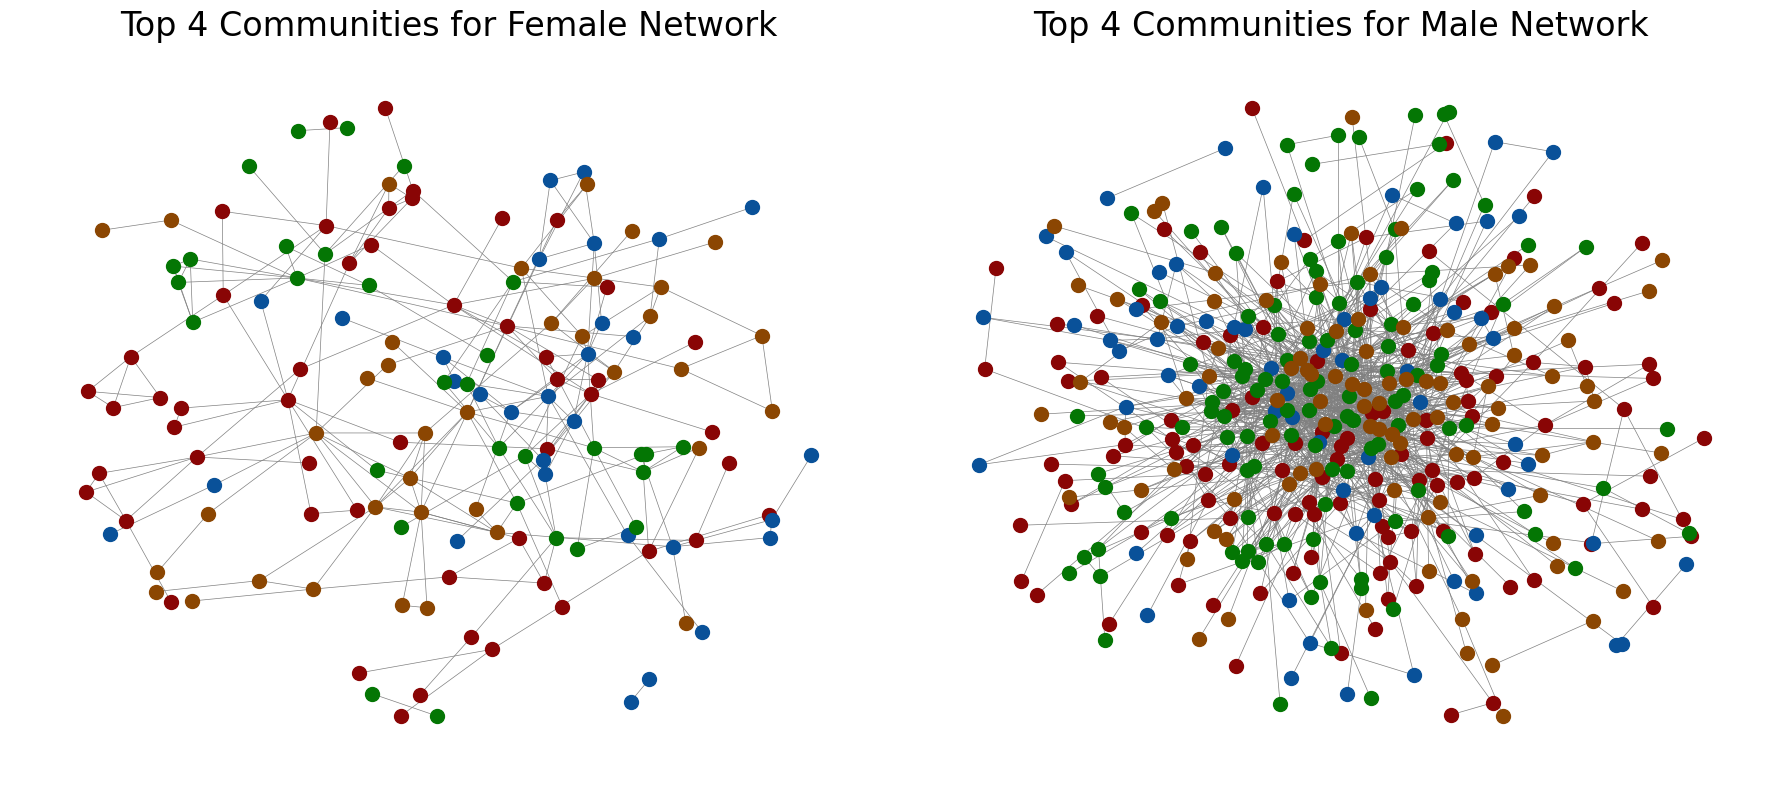

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_top_communities_side_by_side(
    f_largest, m_largest,
    f_communities_ids, m_communities_ids,
    "Top 4 Communities for Female Network", "Top 4 Communities for Male Network"
)
#save the figure
plt.savefig("plots/top_4_communities_side_by_side.png")

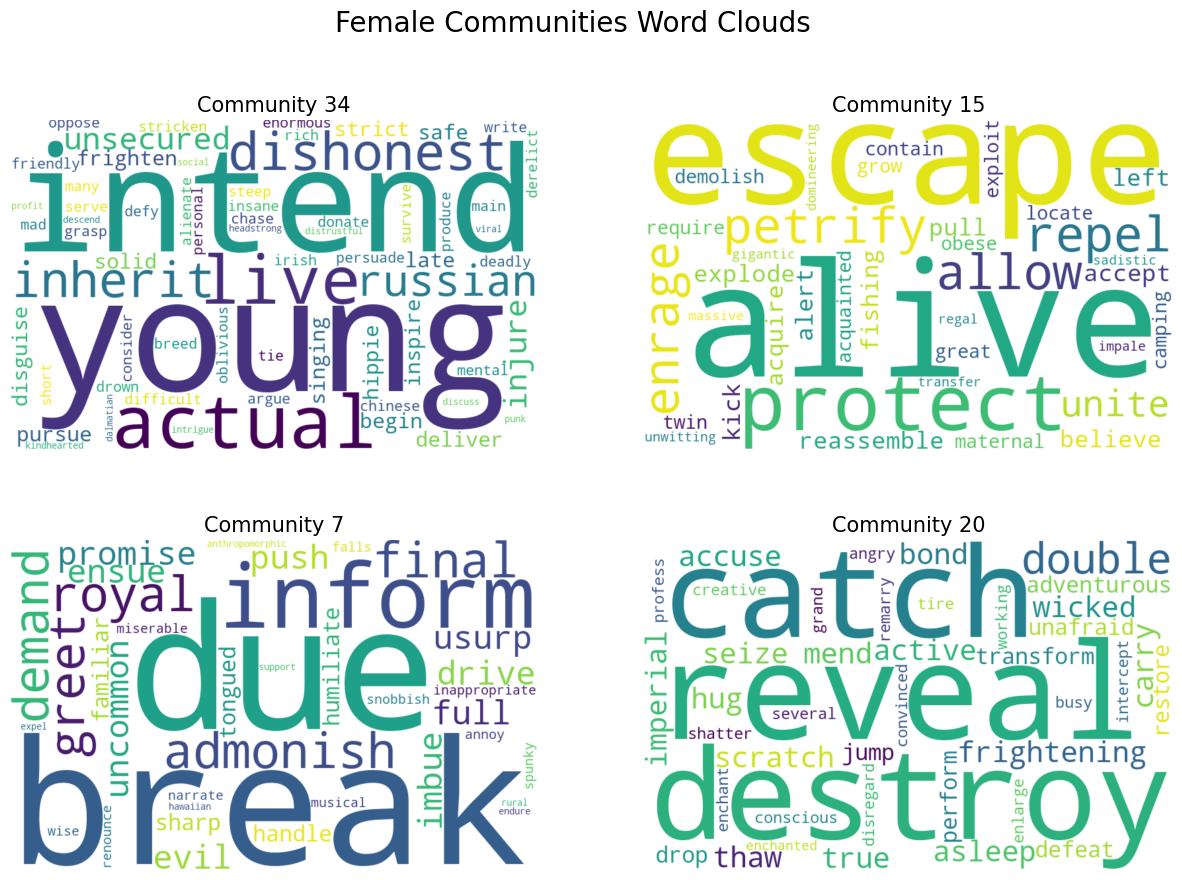

In [ ]:
#we create a dict with the community and all the nodes from f_largest
top_nodes_per_f_comm_dict = {}
for comm_id in f_communities_ids:
    nodes = [n for n, d in f_largest.nodes(data=True) if d['community'] == comm_id]
    comm_nodes = [n for n in f_largest if n in nodes]
    top_nodes_per_f_comm_dict[comm_id] = comm_nodes
#word clouds for each community
i = 0
plt.figure(figsize=(15, 10))
plt.suptitle("Female Communities Word Clouds", size=20)
for comm_id, nodes in top_nodes_per_f_comm_dict.items():
    top_nodes = [n for n in nodes if f_largest.nodes[n].get('pos') in ['VERB', 'ADJ']]
    words = ' '.join(top_nodes)
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(words)
    #create a 2x2 subplot for the 4 communities
    plt.subplot(2, 2, i+1)
    plt.title(f"Community {comm_id}", size=15)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    i += 1
#save the figure
plt.savefig("plots/female_communities_wordclouds.png")

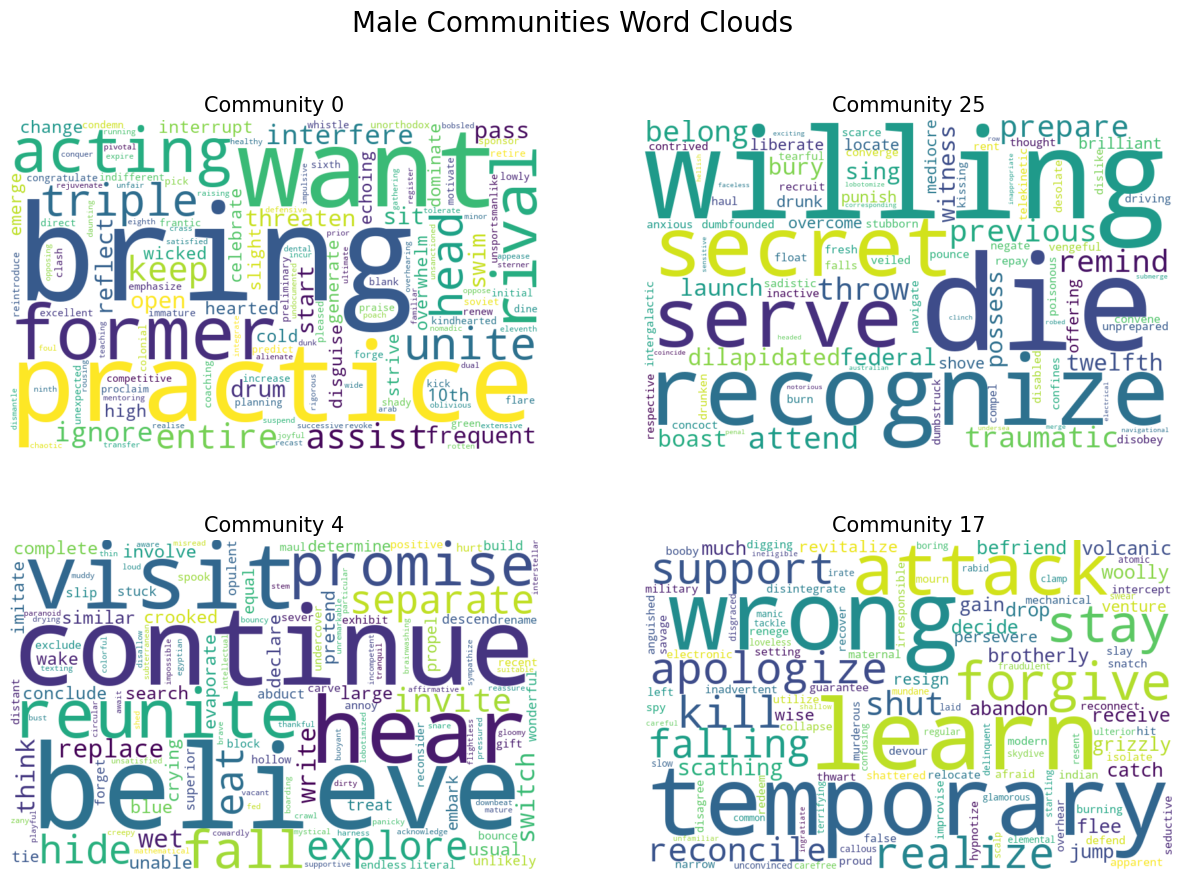

In [ ]:
#we create a dict with the community and all the nodes from f_largest
top_nodes_per_m_comm_dict = {}
for comm_id in m_communities_ids:
    nodes = [n for n, d in m_largest.nodes(data=True) if d['community'] == comm_id]
    comm_nodes = [n for n in m_largest if n in nodes]
    top_nodes_per_m_comm_dict[comm_id] = comm_nodes
#word clouds for each community
i = 0
plt.figure(figsize=(15, 10))
plt.suptitle("Male Communities Word Clouds", size=20)
for comm_id, nodes in top_nodes_per_m_comm_dict.items():
    top_nodes = [n for n in nodes if m_largest.nodes[n].get('pos') in ['VERB', 'ADJ']]
    words = ' '.join(top_nodes)
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(words)
    #create a 2x2 subplot for the 4 communities
    plt.subplot(2, 2, i+1)
    plt.title(f"Community {comm_id}", size=15)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    i += 1
#save the figure
plt.savefig("plots/male_communities_wordclouds.png")

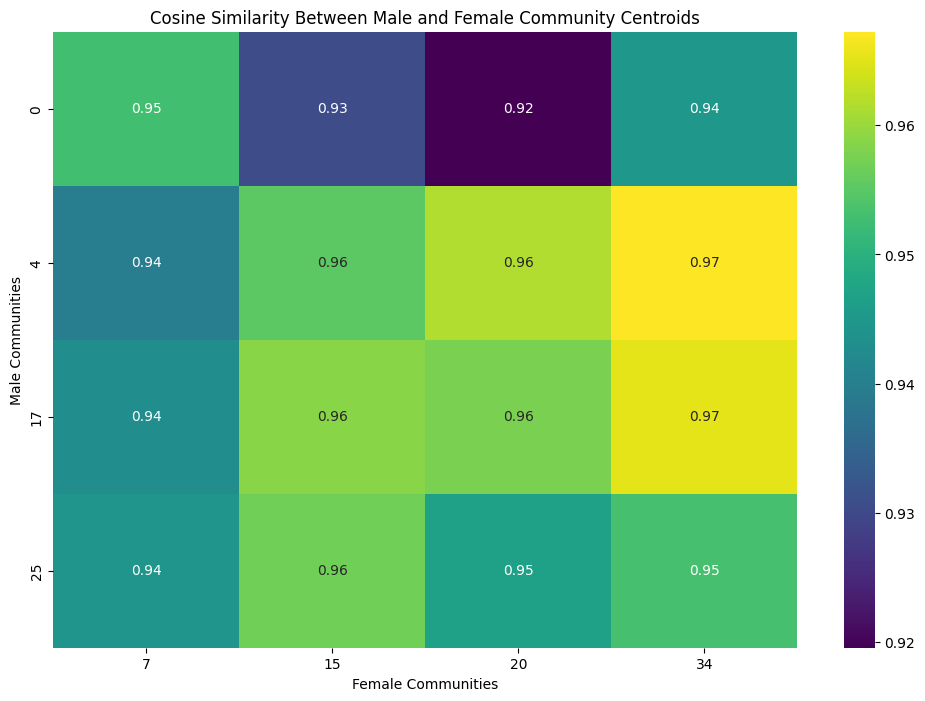

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

#we filter the community vectors to only include the top 4 communities
m_community_vectors_filter = {k: v for k, v in m_community_vectors.items() if k in m_communities_ids}
f_community_vectors_filter= {k: v for k, v in f_community_vectors.items() if k in f_communities_ids}
#then we create matrices from the vectors
m_ids, m_vecs = zip(*m_community_vectors_filter.items())
f_ids, f_vecs = zip(*f_community_vectors_filter.items())

m_matrix = np.vstack(m_vecs)
f_matrix = np.vstack(f_vecs)

# we compute the cosine similarity between the male and female community centroids
similarity_matrix = cosine_similarity(m_matrix, f_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", xticklabels=f_ids, yticklabels=m_ids, cmap="viridis")
plt.xlabel("Female Communities")
plt.ylabel("Male Communities")
plt.title("Cosine Similarity Between Male and Female Community Centroids")
plt.savefig("plots/community_centroid_similarity_heatmap.png")
plt.show()



We compared the communities in the male and female networks by looking at the average word embeddings (centroids) for each community. Then we measured how similar these centroids are using cosine similarity. The values were very high (0.9–0.97), which means that the words grouped together in the communities are mostly similar in meaning across both networks. Only small differences exist between some communities.